In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)

### Leitura dos dados

* Variável	Descrição
* Min.	Minutos jogados na partida.
* Gols	Total de gols marcados.
* Assis.	Total de assistências (passe que resulta diretamente em gol).
* xG	Expected Goals — probabilidade de marcar gols com base na qualidade das finalizações.
* npxG	Non-Penalty Expected Goals — xG excluindo cobranças de pênaltis.
* xAG	Expected Assisted Goals — expectativa de gols gerados a partir dos passes (potencial de assistência).
* SCA	Shot-Creating Actions — número de ações que levam a um chute (passe, drible, falta sofrida, etc.).
* GCA	Goal-Creating Actions — número de ações que levam diretamente a um gol.
* Cmp	Passes completados.
* Att	Passes tentados.
* Cmp%	Porcentagem de passes completados sobre os tentados.
* PrgP	Progressive Passes — passes que avançam significativamente o time no campo.
* Conduções	Conduções realizadas (quando o jogador leva a bola em posse por uma distância significativa).
* PrgC	Progressive Carries — conduções progressivas, que movem a bola significativamente em direção ao gol adversário.
* Tent	Tentativas de dribles.
* Suc	Dribles bem-sucedidos.

In [3]:
df = pd.read_csv('database.csv')

In [4]:
df.head()

,Jogador,Time,#,Nação,Pos.,Idade,Min.,Gols,Assis.,PB,PT,TC,CaG,CrtsA,CrtV,Contatos,Div,Crts,Bloqueios,xG,npxG,xAG,SCA,GCA,Cmp,Att,Cmp%,PrgP,Conduções,PrgC,Tent,Suc,Data
0,Éder,Criciúma,23,ITA,FW,37-150,57.0,0,0,0,0,1,0,0,0,20.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,16.0,"75,0",3.0,17.0,0.0,0.0,0.0,2024-04-13
1,Yannick Bolasie,Criciúma,11,COD,FW,34-325,33.0,0,0,0,0,0,0,1,0,9.0,0.0,0,0.0,0.0,0.0,0.1,4.0,0.0,4.0,5.0,"80,0",0.0,6.0,3.0,5.0,3.0,2024-04-13
2,Renato Kayser,Criciúma,79,BRA,FW,28-056,85.0,1,0,0,0,3,1,0,0,23.0,0.0,0,1.0,0.5,0.5,0.1,1.0,0.0,10.0,15.0,"66,7",4.0,14.0,0.0,1.0,0.0,2024-04-13
3,Arthur,Criciúma,35,BRA,FW,31-303,5.0,0,0,0,0,0,0,0,0,6.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,"83,3",1.0,2.0,0.0,1.0,1.0,2024-04-13
4,Marquinhos Gabriel,Criciúma,10,BRA,AM,33-267,77.0,0,0,0,0,1,1,1,0,40.0,0.0,1,2.0,0.0,0.0,0.3,4.0,1.0,22.0,24.0,"91,7",3.0,24.0,2.0,7.0,5.0,2024-04-13


In [5]:

def idade_em_decimal(valor):
    try:
        anos, dias = valor.split('-')
        return int(anos) + int(dias) / 365
    except:
        return np.nan

df['Idade_decimal'] = df['Idade'].apply(idade_em_decimal)

# Converter datas
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# Corrigir porcentagens: substituir vírgula por ponto e converter
df['Cmp%'] = df['Cmp%'].astype(str).str.replace(',', '.').astype(float)

# Verificar e converter outras colunas que possam ter vírgula no lugar do ponto
colunas_convert = ['Cmp', 'Att', 'PrgP', 'Conduções', 'PrgC', 'Tent', 'Suc', 'Min.', 'Gols', 'Assis.']
for col in colunas_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:

print("Formato dos dados:", df.shape)
print("\nColunas:")
print(df.columns.tolist())

print("\nInformações gerais:")
print(df.info())

print("\nVerificando valores nulos:")
print(df.isnull().sum())

# Descrição estatística das variáveis numéricas
print("\nResumo estatístico das variáveis numéricas:")
print(df.describe())

Formato dos dados: (11682, 34)

Colunas:
['Jogador', 'Time', '#', 'Nação', 'Pos.', 'Idade', 'Min.', 'Gols', 'Assis.', 'PB', 'PT', 'TC', 'CaG', 'CrtsA', 'CrtV', 'Contatos', 'Div', 'Crts', 'Bloqueios', 'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Conduções', 'PrgC', 'Tent', 'Suc', 'Data', 'Idade_decimal']

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Jogador        11682 non-null  object        
 1   Time           11682 non-null  object        
 2   #              11682 non-null  int64         
 3   Nação          11676 non-null  object        
 4   Pos.           11682 non-null  object        
 5   Idade          11676 non-null  object        
 6   Min.           11681 non-null  float64       
 7   Gols           11682 non-null  int64         
 8   Assis.         11682 non-null

C:\Users\User\AppData\Local\Temp\ipykernel_6708\199694444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Pos.', order=df['Pos.'].value_counts().index, palette='viridis')


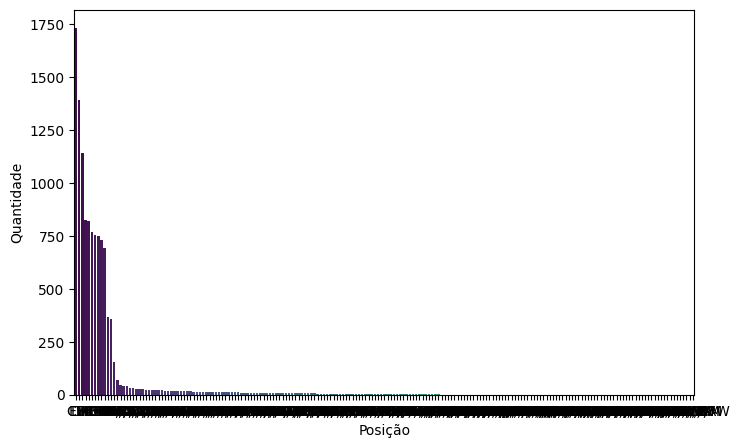

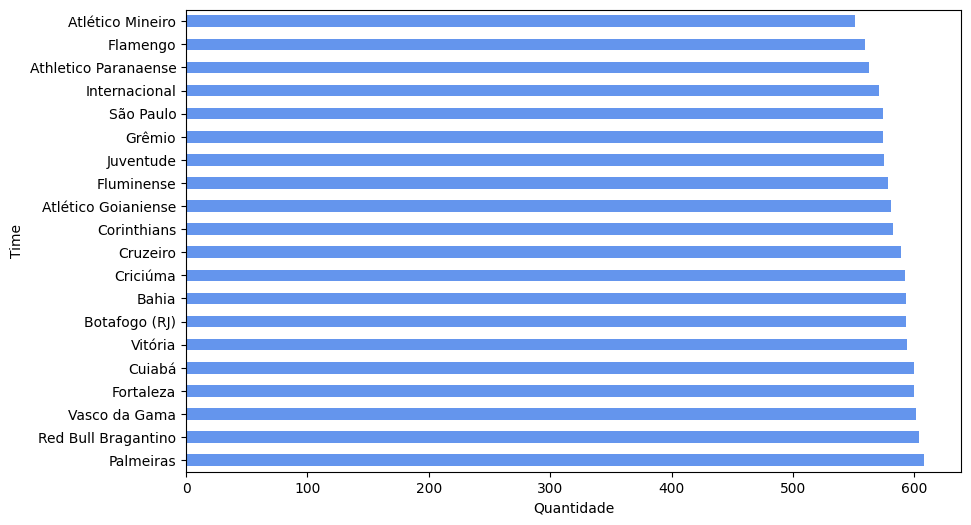

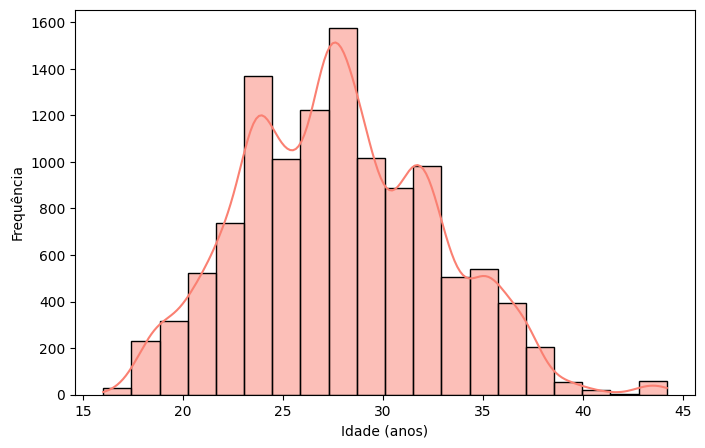

C:\Users\User\AppData\Local\Temp\ipykernel_6708\199694444.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_goleadores['Gols'], y=top_goleadores.index, palette='rocket')


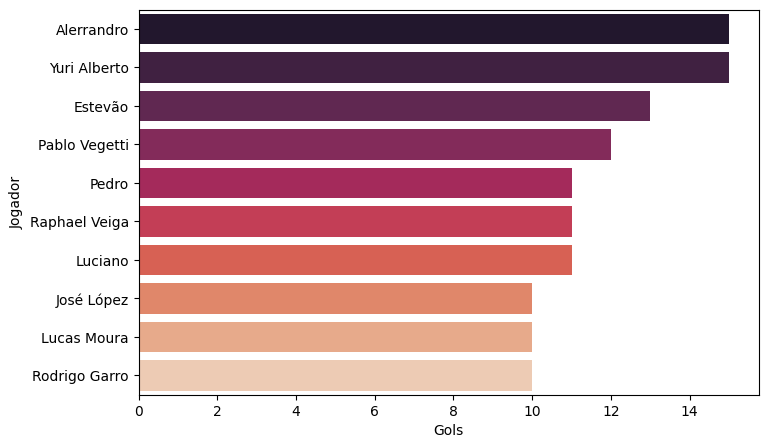

C:\Users\User\AppData\Local\Temp\ipykernel_6708\199694444.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_assistencias['Assis.'], y=top_assistencias.index, palette='mako')


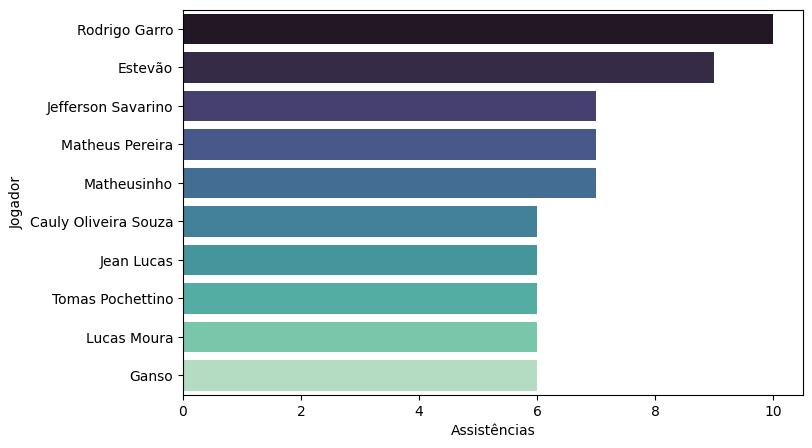

In [21]:
# Distribuição dos jogadores por posição
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Pos.', order=df['Pos.'].value_counts().index, palette='viridis')
# plt.title('Distribuição dos Jogadores por Posição')
plt.xlabel('Posição')
plt.ylabel('Quantidade')
plt.show()

# Distribuição dos jogadores por time
plt.figure(figsize=(10, 6))
df['Time'].value_counts().plot(kind='barh', color='cornflowerblue')
# plt.title('Distribuição dos Jogadores por Time')
plt.xlabel('Quantidade')
plt.ylabel('Time')
plt.show()

# Distribuição da idade
plt.figure(figsize=(8, 5))
sns.histplot(df['Idade_decimal'], bins=20, kde=True, color='salmon')
# plt.title('Distribuição da Idade dos Jogadores')
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.show()

# Top 10 goleadores
top_goleadores = df[['Jogador', 'Gols']].groupby('Jogador').sum().sort_values(by='Gols', ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_goleadores['Gols'], y=top_goleadores.index, palette='rocket')
# plt.title('Top 10 Jogadores com Mais Gols')
plt.xlabel('Gols')
plt.ylabel('Jogador')
plt.show()

# Top 10 assistências
top_assistencias = df[['Jogador', 'Assis.']].groupby('Jogador').sum().sort_values(by='Assis.', ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_assistencias['Assis.'], y=top_assistencias.index, palette='mako')
# plt.title('Top 10 Jogadores com Mais Assistências')
plt.xlabel('Assistências')
plt.ylabel('Jogador')
plt.show()




Total de atacantes: 1360
Outliers detectados: 14


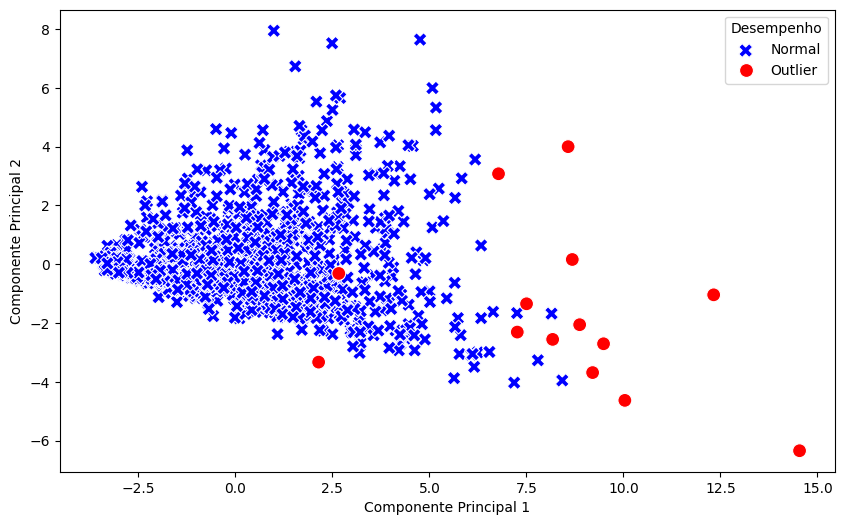


Jogadores Outliers Detectados:
                Jogador                 Time  Min.  Gols  Assis.  Outlier
914            Paulinho     Atlético Mineiro  78.0     1       1       -1
961     Matheus Pereira             Cruzeiro  89.0     1       0       -1
2510   Franco Cristaldo               Grêmio  83.0     0       0       -1
3272    Matheus Pereira             Cruzeiro  90.0     0       1       -1
3492       Alan Patrick        Internacional  90.0     1       0       -1
3506               Hulk     Atlético Mineiro  90.0     0       1       -1
3749    Matheus Pereira             Cruzeiro  90.0     1       0       -1
3932    Matheus Pereira             Cruzeiro  90.0     0       0       -1
5082               Hulk     Atlético Mineiro  90.0     2       0       -1
5671               Hulk     Atlético Mineiro  90.0     2       0       -1
5902           Paulinho     Atlético Mineiro  90.0     0       0       -1
10897      Ángel Romero          Corinthians   9.0     0       2       -1
11503 

In [17]:
# Filtrar apenas atacantes
df_fw = df[(df['Pos.'] == 'FW')].copy()

# Features de desempenho
features_fw = [
    'Min.', 'Gols', 'Assis.', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
    'Cmp', 'Att', 'Cmp%', 'PrgP', 'Conduções', 'PrgC', 'Tent', 'Suc'
]

for col in ['Cmp%', 'xG', 'npxG', 'xAG']:
    df_fw[col] = df_fw[col].astype(str).str.replace(',', '.').astype(float)

X_fw = df_fw[features_fw].dropna()
df_fw_clean = df_fw.loc[X_fw.index].copy()

# Padronizar
scaler = StandardScaler()
X_scaled_fw = scaler.fit_transform(X_fw)

# === 3. Aplicar Isolation Forest ===
iso_forest = IsolationForest(contamination=0.01, random_state=42)  
outlier_pred = iso_forest.fit_predict(X_scaled_fw)

# Adicionar coluna de outlier (1 = normal, -1 = outlier)
df_fw_clean['Outlier'] = outlier_pred

# === 4. Resumo ===
print(f"Total de atacantes: {len(df_fw_clean)}")
print(f"Outliers detectados: {(df_fw_clean['Outlier'] == -1).sum()}")

# === 5. Visualização PCA com outliers ===
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_fw)
df_fw_clean['PCA1'] = X_pca[:, 0]
df_fw_clean['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_fw_clean,
    x='PCA1',
    y='PCA2',
    hue='Outlier',
    palette={1: 'blue', -1: 'red'},
    style='Outlier',
    s=100
)
# plt.title('Detecção de Outliers em Atacantes com Isolation Forest')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Desempenho', labels=['Normal', 'Outlier'])
plt.show()

# === 6. Listar jogadores outliers ===
outliers = df_fw_clean[df_fw_clean['Outlier'] == -1]
print("\nJogadores Outliers Detectados:")
print(outliers[['Jogador', 'Time', 'Min.', 'Gols', 'Assis.', 'Outlier']])

In [15]:
variancia_acumulada = np.cumsum(pca.explained_variance_ratio_)
print(variancia_acumulada)

[0.35445412 0.48419673]


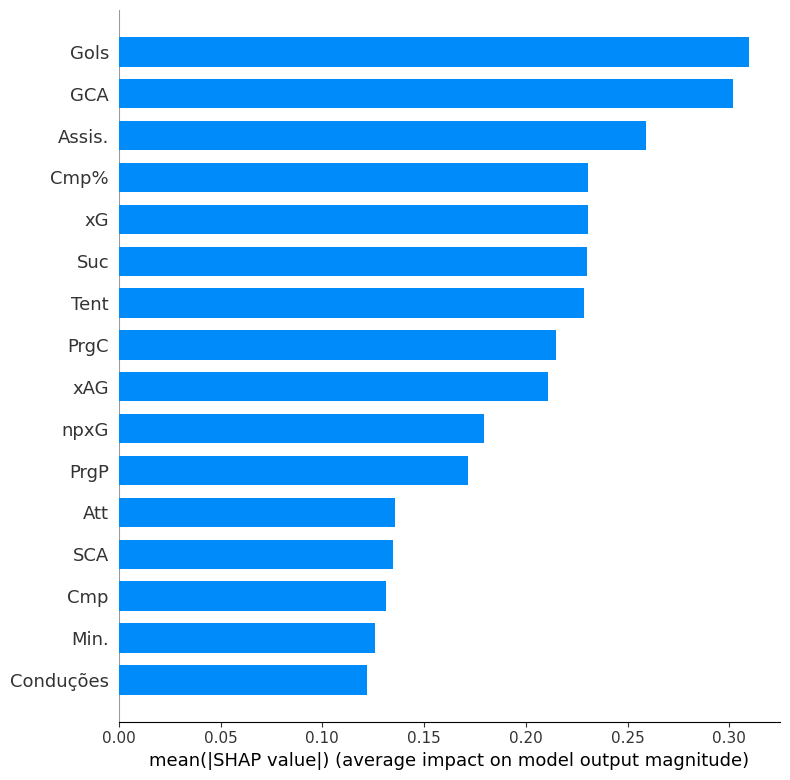

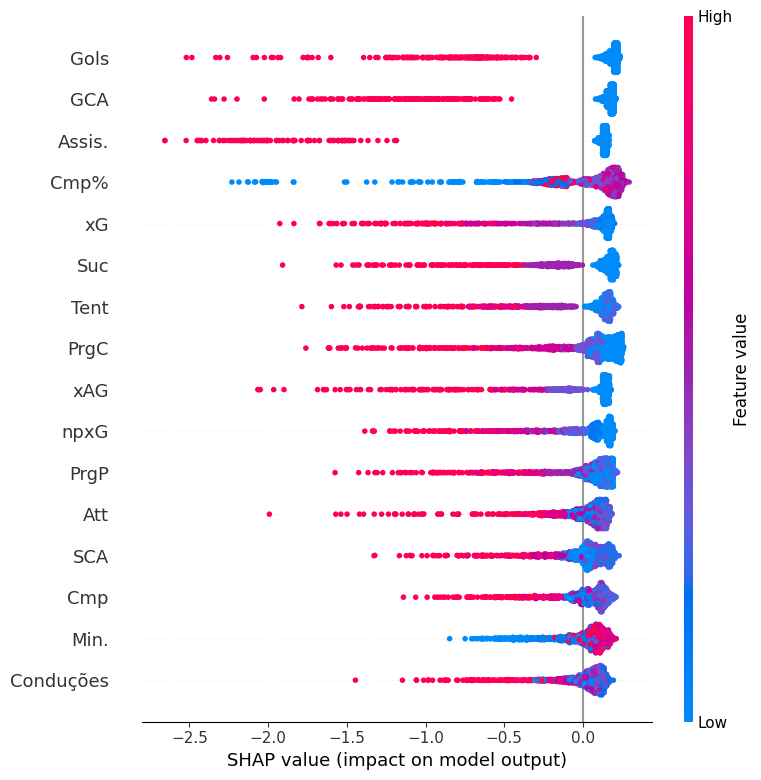


Importância das variáveis segundo SHAP:
      Feature  Mean_Absolute_SHAP
1        Gols            0.309381
7         GCA            0.301925
2      Assis.            0.258825
10       Cmp%            0.230572
3          xG            0.230471
15        Suc            0.230023
14       Tent            0.228376
13       PrgC            0.215025
5         xAG            0.211043
4        npxG            0.179384
11       PrgP            0.171363
9         Att            0.135770
6         SCA            0.134529
8         Cmp            0.131300
0        Min.            0.125747
12  Conduções            0.122129


In [23]:
import shap

# Criar o explicador do SHAP
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(X_scaled_fw)

# === 8. Plotagem dos Resultados SHAP ===

# Gráfico de barras dos principais atributos
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_fw, plot_type="bar")
plt.show()

# Gráfico tipo swarm (distribuição dos impactos)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_fw)
plt.show()

# === 9. Tabela dos atributos mais importantes ===
# Cálculo da média dos valores absolutos dos SHAP values
shap_abs_mean = np.abs(shap_values).mean(axis=0)

# Criar dataframe com os resultados
shap_importance = pd.DataFrame({
    'Feature': X_fw.columns,
    'Mean_Absolute_SHAP': shap_abs_mean
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)

print("\nImportância das variáveis segundo SHAP:")
print(shap_importance)


Interpretação local para o jogador: Paulinho


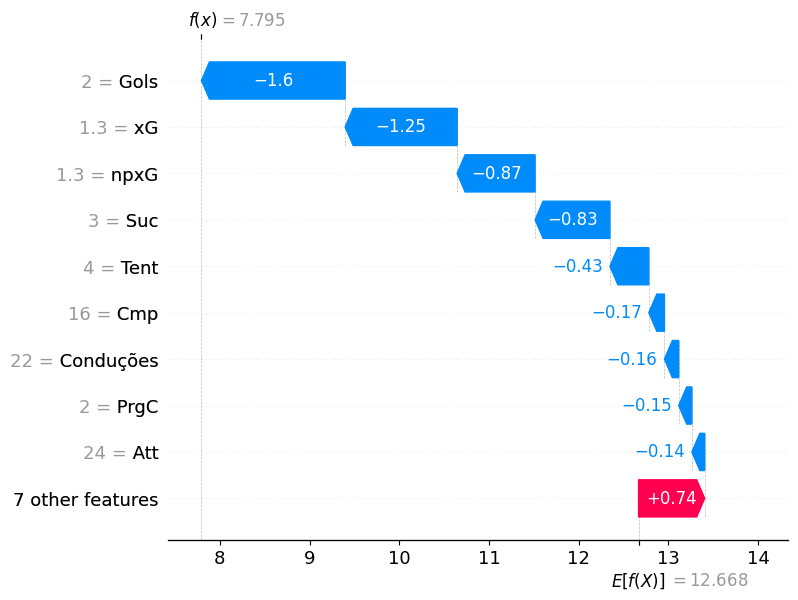

In [25]:
jogador_idx = df_fw_clean[df_fw_clean['Outlier'] == -1].index[0]

# Nome do jogador
jogador_nome = df_fw_clean.loc[jogador_idx, 'Jogador']
print(f"\nInterpretação local para o jogador: {jogador_nome}")

# Criar gráfico waterfall (SHAP local)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[jogador_idx],
        base_values=explainer.expected_value[0],
        data=X_fw.iloc[jogador_idx],
        feature_names=X_fw.columns.tolist()
    )
)


Interpretação local para o jogador: Éder


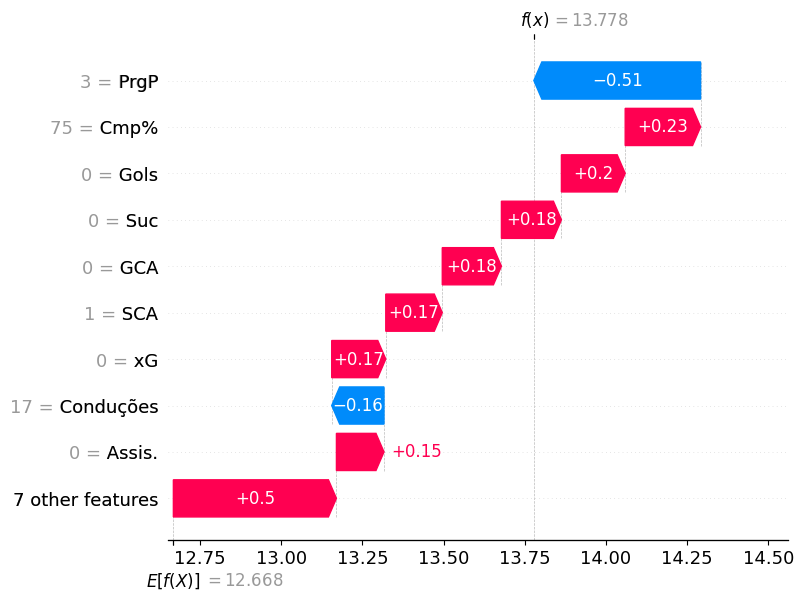

In [26]:
jogador_idx = df_fw_clean[df_fw_clean['Outlier'] == 1].index[0]

# Nome do jogador
jogador_nome = df_fw_clean.loc[jogador_idx, 'Jogador']
print(f"\nInterpretação local para o jogador: {jogador_nome}")

# Criar gráfico waterfall (SHAP local)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[jogador_idx],
        base_values=explainer.expected_value[0],
        data=X_fw.iloc[jogador_idx],
        feature_names=X_fw.columns.tolist()
    )
)

In [ ]:
limiar_xG = df_fw_clean['xG'].median() 

# Criar nova coluna 'Desempenho'
def classifica_desempenho(row):
    if row['Outlier'] == 1:
        return 'Desempenho Normal'
    else:
        if row['xG'] >= limiar_xG:
            return 'Alto Desempenho'
        else:
            return 'Baixo Desempenho'

df_fw_clean['Desempenho'] = df_fw_clean.apply(classifica_desempenho, axis=1)


print(df_fw_clean['Desempenho'].value_counts())

print(df_fw_clean[['Jogador', 'xG', 'Outlier', 'Desempenho']].sort_values(by='xG', ascending=False).head(10))


Desempenho
Desempenho Normal    1346
Alto Desempenho        12
Baixo Desempenho        2
Name: count, dtype: int64
                 Jogador   xG  Outlier         Desempenho
5671                Hulk  1.7       -1    Alto Desempenho
10895       Yuri Alberto  1.7        1  Desempenho Normal
11624  Luciano Rodríguez  1.6        1  Desempenho Normal
4637          Kauã Elias  1.6        1  Desempenho Normal
3060     Oscar Estupiñan  1.6        1  Desempenho Normal
4132                Hulk  1.5        1  Desempenho Normal
1344       Everaldo Stum  1.5        1  Desempenho Normal
11580       Yuri Alberto  1.5        1  Desempenho Normal
2231   Gonzalo Mastriani  1.5        1  Desempenho Normal
6941        Rafael Borré  1.4        1  Desempenho Normal


In [85]:

features_analise = [
    'Min.', 'Gols', 'Assis.', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
    'Cmp', 'Att', 'Cmp%', 'PrgP', 'Conduções', 'PrgC', 'Tent', 'Suc'
]


desc_por_desempenho = df_fw_clean.groupby('Desempenho')[features_analise].describe().round(2)

desc_por_desempenho

Min.                                                \
                    count   mean    std   min    25%   50%    75%   max   
Desempenho                                                                
Alto Desempenho      12.0  82.67  19.48  22.0  87.50  90.0  90.00  90.0   
Baixo Desempenho      2.0  49.50  57.28   9.0  29.25  49.5  69.75  90.0   
Desempenho Normal  1346.0  53.90  29.85   1.0  24.00  63.0  82.00  90.0   

                     Gols                                       Assis.        \
                    count  mean   std  min  25%  50%  75%  max   count  mean   
Desempenho                                                                     
Alto Desempenho      12.0  0.83  0.72  0.0  0.0  1.0  1.0  2.0    12.0  0.33   
Baixo Desempenho      2.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0     2.0  1.00   
Desempenho Normal  1346.0  0.19  0.43  0.0  0.0  0.0  0.0  2.0  1346.0  0.07   

                                                      xG                   \
                    std  min  25%  50%  75%  max   count  mean   std  min   
Desempenho                                                                  
Alto Desempenho    0.49  0.0  0.0  0.0  1.0  1.0    12.0  0.61  0.54  0.1   
Baixo Desempenho   1.41  0.0  0.5  1.0  1.5  2.0     2.0  0.00  0.00  0.0   
Desempenho Normal  0.26  0.0  0.0  0.0  0.0  2.0  1346.0  0.20  0.30  0.0   

                                          npxG                               \
                   25%   50%  75%  max   count  mean   std  min   25%   50%   
Desempenho                                                                    
Alto Desempenho    0.2  0.35  0.9  1.7    12.0  0.34  0.35  0.0  0.18  0.25   
Baixo Desempenho   0.0  0.00  0.0  0.0     2.0  0.00  0.00  0.0  0.00  0.00   
Desempenho Normal  0.0  0.10  0.3  1.7  1346.0  0.17  0.26  0.0  0.00  0.10   

                                 xAG                                          \
                    75%  max   count  mean   std  min   25%   50%   75%  max   
Desempenho                                                                     
Alto Desempenho    0.32  1.3    12.0  0.18  0.21  0.0  0.00  0.15  0.30  0.7   
Baixo Desempenho   0.00  0.0     2.0  0.80  0.71  0.3  0.55  0.80  1.05  1.3   
Desempenho Normal  0.20  1.7  1346.0  0.06  0.13  0.0  0.00  0.00  0.10  1.0   

                      SCA                                           GCA        \
                    count  mean   std  min  25%  50%  75%   max   count  mean   
Desempenho                                                                      
Alto Desempenho      12.0  6.00  2.17  2.0  5.0  5.5  7.0  10.0    12.0  1.00   
Baixo Desempenho      2.0  6.00  5.66  2.0  4.0  6.0  8.0  10.0     2.0  1.00   
Desempenho Normal  1346.0  1.42  1.48  0.0  0.0  1.0  2.0   9.0  1346.0  0.16   

                                                      Cmp                     \
                    std  min  25%  50%   75%  max   count   mean    std  min   
Desempenho                                                                     
Alto Desempenho    0.95  0.0  0.0  1.0  1.25  3.0    12.0  33.17  14.09  3.0   
Baixo Desempenho   1.41  0.0  0.5  1.0  1.50  2.0     2.0  34.00  41.01  5.0   
Desempenho Normal  0.43  0.0  0.0  0.0  0.00  3.0  1346.0   8.89   6.50  0.0   

                                              Att                           \
                    25%   50%   75%   max   count   mean    std  min   25%   
Desempenho                                                                   
Alto Desempenho    21.0  38.5  45.0  48.0    12.0  40.92  17.15  3.0  28.0   
Baixo Desempenho   19.5  34.0  48.5  63.0     2.0  45.00  52.33  8.0  26.5   
Desempenho Normal   4.0   7.0  12.0  62.0  1346.0  12.35   8.23  1.0   6.0   

                                        Cmp%                             \
                    50%    75%   max   count   mean    std   min    25%   
Desempenho                                                                
Alto Des

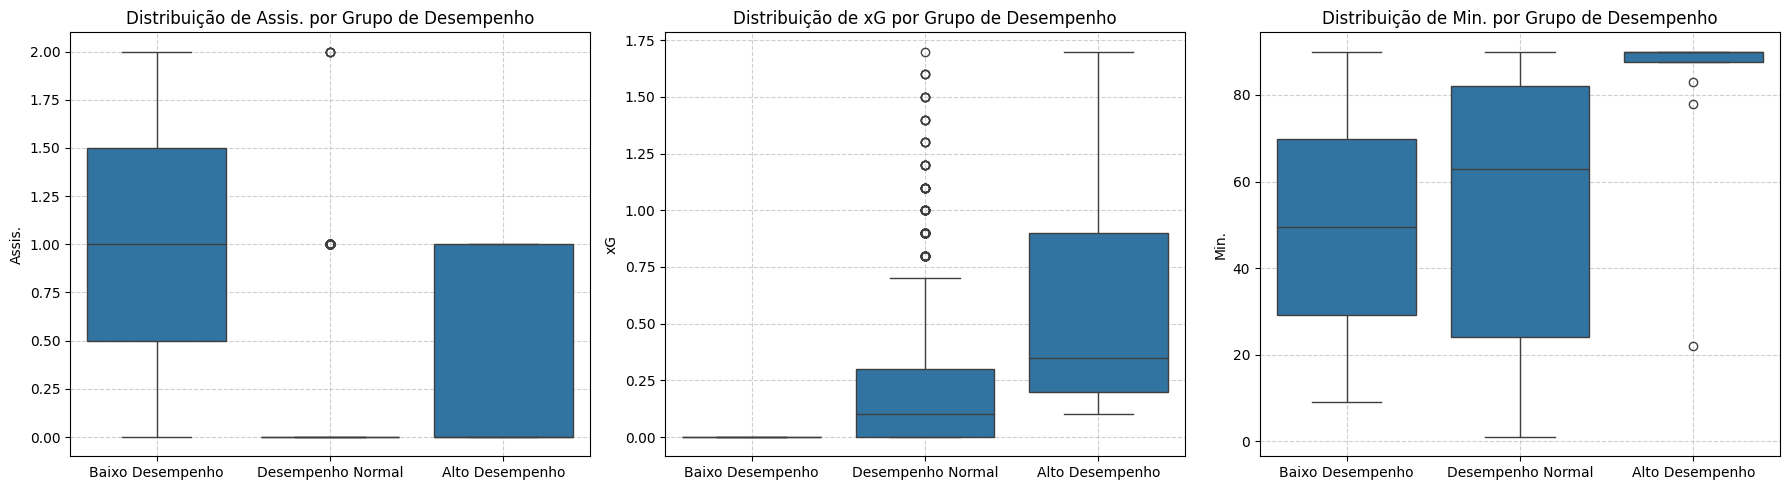

In [87]:
features_graficos = ['Assis.', 'xG', 'Min.']
plt.figure(figsize=(18,5))

for i, feature in enumerate(features_graficos, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df_fw_clean, x='Desempenho', y=feature, 
                order=['Baixo Desempenho', 'Desempenho Normal', 'Alto Desempenho'])
    plt.title(f'Distribuição de {feature} por Grupo de Desempenho')
    plt.xlabel('')
    plt.ylabel(feature)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()